<a href="https://colab.research.google.com/github/poponzu/Research/blob/master/DAE%E8%BF%BD%E5%8A%A0%E7%94%A8_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
!pip install tensorflow==1.14.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 48 kB/s 
     |████████████████████████████████| 50 kB 8.6 MB/s 
     |████████████████████████████████| 3.1 MB 53.7 MB/s 
     |████████████████████████████████| 488 kB 58.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

In [5]:
!pip install keras==2.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 377 kB 23.0 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0


In [6]:
import numpy as np
import tensorflow as tf
import random as rn
import numpy as np

import os

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
# import tensorflow as tf
# print(tf.__version__)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)

# session_conf = tf.compat.v1.ConfigProto(
#     intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
# )

from tensorflow import keras 
from keras import backend as K

tf.set_random_seed(1234)
# tf.random.set_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from keras.layers import Input, Dense,LSTM,RepeatVector,GRU,Dropout,Reshape
from keras.layers import*
from keras.models import Model
from keras.models import Sequential
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
from math import sqrt
import random
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [7]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[:,0][-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = []
	for x in X:
   		 new_row = new_row+[i for i in x]
            
	new_row.append(value) 
	new_row_2 = np.array(new_row)
	new_row_2 = new_row_2.reshape((1,new_row_2.shape[0]))
	inverted = scaler.inverse_transform(new_row_2)
	return inverted[0, -1]


def create_dataset(dataset,features, look_back=1):
	dataset = np.insert(dataset,[0]*look_back,0)    
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	dataY= np.array(dataY)        
	dataY = np.reshape(dataY,(dataY.shape[0],features))
	dataset = np.concatenate((dataX,dataY),axis=1)  
	return dataset



# convert series to supervised learning
def series_to_supervised(data,features, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	x = np.zeros(features, dtype=np.int)
	for i in range(n_in):
		data = np.insert(data,x,0)
	data = data.reshape(int(data.shape[0]/features),features) 
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(batch_size, X.shape[0], X.shape[1])
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


# def read_data(): 

	
# 	window_size = 0
# 	features = 8


# 	series = read_csv('pollution.csv', header=0, index_col=0)	
# 	raw_values = series.values

# 	# integer encode wind direction
# 	encoder = LabelEncoder()
# 	raw_values[:,4] = encoder.fit_transform(raw_values[:,4])

# 	# transform data to be stationary
# 	diff = difference(raw_values, 1)


# 	dataset = diff.values
# 	dataset = create_dataset(dataset,features,window_size)


# 	return dataset,raw_values

In [8]:
space = {'seq_len':hp.choice('seq_len',[5,10,15,20,25,30]),
         'epochs_pre':hp.choice('epochs_pre',[i for i in range(50,1000)]),
         'epochs_finetune':hp.choice('epochs_finetune',[i for i in range(50,500)]),
         'units':hp.choice('units',[i for i in range(1,50)]),
         'dropout':hp.choice('dropout',[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]),
         'batch_size':hp.choice('batch_size',[73, 146, 219])}

In [9]:
params = {'seq_len': 10,
          'epochs_pre': 100,
          'epochs_finetune': 50,
          'units': 20,
          'dropout': 0.2,
          'batch_size': 73}

In [10]:
hidden_layers = [35,49,4]
batch_size = 219
dropout = 0.2
seq_len = 25
epochs_pre  = [625,115,933]
# デバッグ用
epochs_pre  = [1,1,1]
epochs_finetune = 197
epochs_finetune = 1
window_size = 0
features = 8

In [52]:
series = read_csv('/content/drive/MyDrive/Colab Notebooks/jimang/pollution.csv', header=0, index_col=0)
series.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138,-7,-5.0,1022.0,SE,6.25,2,0


In [11]:
series = read_csv('/content/drive/MyDrive/Colab Notebooks/jimang/pollution.csv', header=0, index_col=0)
raw_values = series.values

# integer encode wind direction
encoder = LabelEncoder()
raw_values[:,4] = encoder.fit_transform(raw_values[:,4])

# transform data to be stationary
diff = difference(raw_values, 1)


dataset = diff.values
dataset = create_dataset(dataset,features,window_size)

In [12]:
# frame as supervised learning
reframed = series_to_supervised(dataset,features, seq_len, 1)
drop = [i for  i in  range(seq_len*features+1,((seq_len+1)*features))]
reframed.drop(reframed.columns[drop], axis=1, inplace=True)
reframed = reframed.values

# split into train and test sets
train_size = 365*24*4
train, test = reframed[0:train_size], reframed[train_size:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# split into input and outputs
x_train,y_train = train_scaled[:,0:-1],train_scaled[:,-1]
x_test,y_test = test_scaled[:,0:-1],test_scaled[:,-1]

# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape(x_train.shape[0],seq_len,features)
x_test = x_test.reshape(x_test.shape[0],seq_len,features)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(35040, 25, 8) (35040,) (8759, 25, 8) (8759,)


In [13]:
print('\nstart pretraining')
print('===============')

timesteps = x_train.shape[1]
input_dim = x_train.shape[2]
trained_encoder = []
x_train_temp = x_train


start pretraining


In [14]:
print('>> 1 LAYERS')
hidden = hidden_layers[0]
epochs = epochs_pre[0]


>> 1 LAYERS


In [15]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [16]:
inputs = Input(batch_shape=(5, timesteps, x_train_temp.shape[2]))
encoded1 = LSTM(
    hidden, # 35
    batch_input_shape=(5, timesteps, x_train_temp.shape[2]),
    stateful=False)(inputs)
encoded2 = LSTM(
    hidden, # 35
    batch_input_shape=(5, timesteps, x_train_temp.shape[2]),
    stateful=True)(inputs)

In [17]:
ae1 = Model(inputs, encoded1)
ae2 = Model(inputs, encoded2)

In [18]:
ae1.predict(x_train_temp[0:5])

array([[ 0.24322765,  0.06178239, -0.17655882, -0.12882254, -0.02688442,
        -0.0721254 ,  0.05387397, -0.11968687,  0.23866737,  0.11617469,
        -0.04865515,  0.3114834 , -0.17449522, -0.23140316, -0.12739022,
        -0.08305719,  0.23297568,  0.07088908,  0.12098511,  0.3627467 ,
         0.0424863 , -0.2135795 ,  0.08458111,  0.08890662,  0.01499828,
        -0.07102045,  0.05547186,  0.09340119,  0.07347936, -0.29601127,
        -0.0165082 ,  0.16104677, -0.30813733, -0.16865839, -0.14752522],
       [ 0.24535778,  0.06087729, -0.17936966, -0.13045558, -0.02807865,
        -0.07171693,  0.05483313, -0.12019384,  0.23945777,  0.11864257,
        -0.04922653,  0.3126094 , -0.17437698, -0.23376803, -0.12811124,
        -0.08466566,  0.23025292,  0.07202914,  0.12235111,  0.36257184,
         0.04224938, -0.21644606,  0.08322715,  0.08907802,  0.01652107,
        -0.07188129,  0.05248745,  0.09324394,  0.07156403, -0.29585463,
        -0.01800653,  0.16023819, -0.3096695 , -0.

In [19]:
ae2.predict(x_train_temp[0:5])

array([[ 0.1273528 ,  0.10068031, -0.12685269,  0.06722263,  0.30900016,
        -0.04228254, -0.08361648,  0.33564928, -0.24645342, -0.14372094,
         0.15147391,  0.11833811, -0.21517964, -0.13915277, -0.01345758,
        -0.08503578,  0.10117726, -0.22256249, -0.21828233,  0.12404889,
         0.14180566,  0.05194278,  0.02936172, -0.22914435,  0.05827786,
         0.06012322,  0.1914436 ,  0.01527736,  0.00603681, -0.06199156,
        -0.0780628 , -0.25579426,  0.04199241,  0.01263958, -0.14798377],
       [ 0.1253904 ,  0.10058086, -0.12856945,  0.06618417,  0.30898133,
        -0.04156291, -0.08436906,  0.33797476, -0.24781086, -0.14120118,
         0.15112396,  0.11739679, -0.21475308, -0.13764223, -0.01528612,
        -0.08608457,  0.10058317, -0.22186351, -0.22034499,  0.12182613,
         0.14354149,  0.05332322,  0.02956992, -0.23015125,  0.05790955,
         0.06411634,  0.19298966,  0.01642885,  0.00484067, -0.06343229,
        -0.07534498, -0.25604504,  0.04141588,  0.

In [20]:
print(f'pretrain Autoencoder: {0} ----> Encoder: {hidden} ----> Epochs: {epochs}')
print(x_train_temp.shape)
print('=============================================================')

inputs = Input(
    # (219, 25, 8)
    batch_shape=(batch_size, timesteps, x_train_temp.shape[2]))
encoded = LSTM(
    hidden, # 35
    batch_input_shape=(batch_size, timesteps, x_train_temp.shape[2]),
    stateful = False)(inputs)
decoded = RepeatVector(timesteps)(encoded) 
decoded = LSTM(input_dim, stateful=False, return_sequences=True)(decoded)

AE = Model(inputs, decoded)

encoder = Model(inputs,encoded)

AE.compile(loss='mean_squared_error', optimizer='Adam')

encoder.compile(loss='mean_squared_error', optimizer='Adam')

AE.summary()

pretrain Autoencoder: 0 ----> Encoder: 35 ----> Epochs: 1
(35040, 25, 8)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (219, 25, 8)              0         
_________________________________________________________________
lstm_3 (LSTM)                (219, 35)                 6160      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (219, 25, 35)             0         
_________________________________________________________________
lstm_4 (LSTM)                (219, 25, 8)              1408      
Total params: 7,568
Trainable params: 7,568
Non-trainable params: 0
_________________________________________________________________


In [21]:
AE.fit(
    x_train_temp, 
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

Epoch 1/1
35040/35040 [==============================] - 9s 251us/step - loss: 0.0692


In [22]:
# store trained encoder and its weights
trained_encoder.append(
    (AE.layers[1], AE.layers[1].get_weights())
)

# update training data
x_train_temp = encoder.predict(x_train_temp, batch_size=batch_size)

In [23]:
x_train_temp.shape

(35040, 35)

In [24]:
# reshape encoded input to 3D
inputs = Input(shape = (x_train_temp.shape[1],)) 
reshape = RepeatVector(timesteps)(inputs)
Repeat = Model(inputs,reshape)

x_train_temp = Repeat.predict(x_train_temp, batch_size=batch_size)

In [25]:
x_train_temp.shape

(35040, 25, 35)

In [26]:
print('>> 2 LAYERS')
hidden = hidden_layers[1]
epochs = epochs_pre[1]

>> 2 LAYERS


In [27]:
print(f'pretrain Autoencoder: {1} ----> Encoder: {hidden} ----> Epochs: {epochs}')
print(x_train_temp.shape)
print('=============================================================')

inputs = Input(
    # (219, 25, 35)
    batch_shape=(batch_size, timesteps, x_train_temp.shape[2]))
encoded = LSTM(
    hidden, # 49
    batch_input_shape=(batch_size, timesteps, x_train_temp.shape[2]),
    stateful = False)(inputs)
decoded = RepeatVector(timesteps)(encoded) 
decoded = LSTM(input_dim, stateful=False, return_sequences=True)(decoded)

AE = Model(inputs, decoded)

encoder = Model(inputs,encoded)

AE.compile(loss='mean_squared_error', optimizer='Adam')

encoder.compile(loss='mean_squared_error', optimizer='Adam')

AE.summary()

pretrain Autoencoder: 1 ----> Encoder: 49 ----> Epochs: 1
(35040, 25, 35)
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (219, 25, 35)             0         
_________________________________________________________________
lstm_5 (LSTM)                (219, 49)                 16660     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (219, 25, 49)             0         
_________________________________________________________________
lstm_6 (LSTM)                (219, 25, 8)              1856      
Total params: 18,516
Trainable params: 18,516
Non-trainable params: 0
_________________________________________________________________


In [28]:
AE.fit(
    x_train_temp, 
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

Epoch 1/1
35040/35040 [==============================] - 16s 464us/step - loss: 0.0506


In [29]:
# store trained encoder and its weights
trained_encoder.append(
    (AE.layers[1], AE.layers[1].get_weights())
)

# update training data
x_train_temp = encoder.predict(x_train_temp, batch_size=batch_size)

In [30]:
x_train_temp.shape

(35040, 49)

In [31]:
# reshape encoded input to 3D
inputs = Input(shape = (x_train_temp.shape[1],)) 
reshape = RepeatVector(timesteps)(inputs)
Repeat = Model(inputs,reshape)

x_train_temp = Repeat.predict(x_train_temp, batch_size=batch_size)

In [32]:
x_train_temp.shape

(35040, 25, 49)

In [33]:
print('>> 3 LAYERS')
hidden = hidden_layers[2]
epochs = epochs_pre[2]

>> 3 LAYERS


In [34]:
print(f'pretrain Autoencoder: {2} ----> Encoder: {hidden} ----> Epochs: {epochs}')
print(x_train_temp.shape)
print('=============================================================')

inputs = Input(
    # (219, 25, 49)
    batch_shape=(batch_size, timesteps, x_train_temp.shape[2]))
encoded = LSTM(
    hidden, # 4
    batch_input_shape=(batch_size, timesteps, x_train_temp.shape[2]),
    stateful = False)(inputs)
decoded = RepeatVector(timesteps)(encoded) 
decoded = LSTM(input_dim, stateful=False, return_sequences=True)(decoded)

AE = Model(inputs, decoded)

encoder = Model(inputs,encoded)

AE.compile(loss='mean_squared_error', optimizer='Adam')

encoder.compile(loss='mean_squared_error', optimizer='Adam')

AE.summary()

pretrain Autoencoder: 2 ----> Encoder: 4 ----> Epochs: 1
(35040, 25, 49)
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (219, 25, 49)             0         
_________________________________________________________________
lstm_7 (LSTM)                (219, 4)                  864       
_________________________________________________________________
repeat_vector_5 (RepeatVecto (219, 25, 4)              0         
_________________________________________________________________
lstm_8 (LSTM)                (219, 25, 8)              416       
Total params: 1,280
Trainable params: 1,280
Non-trainable params: 0
_________________________________________________________________


In [35]:
AE.fit(
    x_train_temp, 
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

Epoch 1/1
35040/35040 [==============================] - 6s 168us/step - loss: 0.1191


In [36]:
# store trained encoder and its weights
trained_encoder.append(
    (AE.layers[1], AE.layers[1].get_weights())
)

# update training data
x_train_temp = encoder.predict(x_train_temp, batch_size=batch_size)

In [37]:
x_train_temp.shape

(35040, 4)

In [38]:
# reshape encoded input to 3D
inputs = Input(shape = (x_train_temp.shape[1],)) 
reshape = RepeatVector(timesteps)(inputs)
Repeat = Model(inputs,reshape)

x_train_temp = Repeat.predict(x_train_temp, batch_size=batch_size)

In [39]:
x_train_temp.shape

(35040, 25, 4)

In [40]:
# Fine-turning
print('\nFine-turning')
print('============')

l = len(trained_encoder)
#build finetuning model
model = Sequential()
for i,encod in enumerate(trained_encoder):
    model.add(encod[0])
    model.layers[-1].set_weights(encod[1])
    model.add(Dropout(dropout))
    if(i+1 != l): model.add(RepeatVector(timesteps))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='Adam')

history = model.fit(
    x_train, 
    y_train, 
    epochs=epochs_finetune, 
    batch_size=batch_size, 
    verbose=1,
    shuffle=True
)


Fine-turning
Epoch 1/1
35040/35040 [==============================] - 12s 333us/step - loss: 0.0217


# Lossの値の可視化

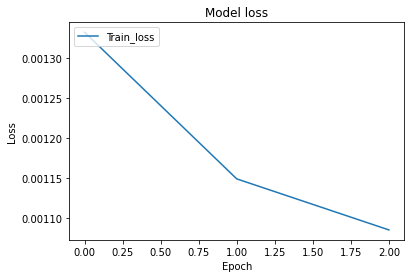

In [51]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_loss', 'Test'], loc='upper left')
plt.show()

In [41]:
# save trained model
model.save('3layer_25.h5')

# redefine the model in order to test with one sample at a time (batch_size = 1)
new_model = Sequential()
new_model.add(
    LSTM(
        hidden_layers[0],
        batch_input_shape=(1, timesteps, input_dim),
        stateful=False)
)
for layer in model.layers[1:]:
    new_model.add(layer)

# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)

In [42]:
def smape(A, F):
    return 100/len(A) * np.sum(np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [43]:
# forecast the entire training dataset to build up state for forecasting
print('Forecasting Training Data')   
predictions_train = list()
for i in range(len(y_train)):
    # make one-step forecast
    X = x_train[i]
    y= y_train[i]
    yhat = forecast_lstm(new_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(raw_values)-i)
    # store forecast
    predictions_train.append(yhat)
    expected = raw_values[:,0][ i+1 ] 
    #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse_train = sqrt(mean_squared_error(raw_values[:,0][1:len(train_scaled)+1], predictions_train))
print('Train RMSE: %.5f' % rmse_train)
# #report performance using RMSPE
# RMSPE_train = RMSPE(raw_values[:,0][1:len(train_scaled)+1],predictions_train)
# print('Train RMSPE: %.5f' % RMSPE_train)
MAE_train = mean_absolute_error(raw_values[:,0][1:len(train_scaled)+1], predictions_train)
print('Train MAE: %.5f' % MAE_train)
# MAPE_train = MAPE(raw_values[:,0][1:len(train_scaled)+1], predictions_train)
# print('Train MAPE: %.5f' % MAPE_train)
SMAPE_train = smape(raw_values[:,0][1:len(train_scaled)+1], predictions_train)
print('Train SMAPE: %.5f' % SMAPE_train)

Forecasting Training Data
Train RMSE: 28.97813
Train MAE: 15.58978
Train SMAPE: 20.24908


In [44]:
SMAPE_train = smape(raw_values[:,0][1:len(train_scaled)+1], predictions_train)
print('Train SMAPE: %.5f' % SMAPE_train)

Train SMAPE: 20.24908


In [45]:
# forecast the test data
print('Forecasting Testing Data')
predictions_test = list()
for i in range(len(y_test)):
    # make one-step forecast
    X = x_test[i]
    y= y_test[i]
    yhat = forecast_lstm(new_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_test.append(yhat)
    expected = raw_values[:,0][len(train) + i + 1]
    #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance using RMSE
rmse_test = sqrt(mean_squared_error(raw_values[:,0][-len(test_scaled):], predictions_test))
print('Test RMSE: %.5f' % rmse_test)
#report performance using RMSPE
# RMSPE_test = RMSPE(raw_values[:,0][-len(test_scaled):], predictions_test)
# print('Test RMSPE: %.5f' % RMSPE_test)
MAE_test = mean_absolute_error(raw_values[:,0][-len(test_scaled):], predictions_test)
print('Test MAE: %.5f' % MAE_test)
# MAPE_test = MAPE(raw_values[:,0][-len(test_scaled):], predictions_test)
# print('Test MAPE: %.5f' % MAPE_test)
SMAPE_test = smape(raw_values[:,0][-len(test_scaled):], predictions_test)
print('Test SMAPE: %.5f' % SMAPE_test)

Forecasting Testing Data
Test RMSE: 25.31777
Test MAE: 14.60041
Test SMAPE: 17.41272


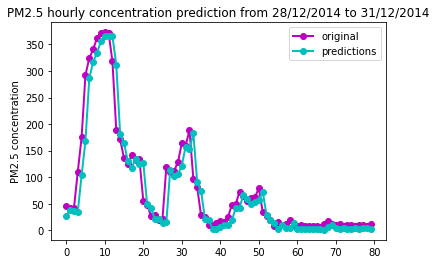

In [46]:
# line plot of observed vs predicted
fig, ax = plt.subplots(1)
ax.plot(raw_values[:,0][-80:],'mo-', label='original',linewidth = 2 )
ax.plot(predictions_test[-80:] ,'co-', label='predictions',linewidth = 2)
#ax.axvline(x=len(train_scaled)+1,color='k', linestyle='--')
ax.legend(loc='upper right')
ax.set_title('PM2.5 hourly concentration prediction from 28/12/2014 to 31/12/2014')
ax.set_ylabel('PM2.5 concentration')
plt.show()